In [3]:
import torch
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import sys

sys.path.insert(1, '../../util/')

import augmentation as aug
import preprocessing_util as util

train_path = '../../data/train.csv'

class MRIDataset(Dataset):
    def __init__(self, path, hyperparameters):
        self.x     = [] #MRI samples
        self.y1    = [] #Coordinate labels
        self.y2    = [] #Severity labels
        self.masks = [] #Label masks
        self.hyperparameters = hyperparameters
        for study in os.listdir(path):
            study_path = os.path.join(path,study)
            # print(study_path)
            for series in os.listdir(study_path):
                data_path = f'{study_path}/{series}/{series}_'
                self.x.append(np.load(f'{data_path}image.npy'))
                self.y1.append(np.load(f'{data_path}coordinates.npy'))
                # self.y2.append(np.load(f'{data_path}labels.npy'))
                self.y2.append(util.load_label_data(train_path, int(study)))
                self.masks.append(np.load(f'{data_path}mask.npy'))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y1 = self.y1[idx]
        y2 = self.y2[idx]
        mask = self.masks[idx]
        #Data augmentation
        
        #Normalize
        x = aug.normalize_volume(x)
        
        #Scaling
        x, y1 = aug.random_scaling(x, y1, self.hyperparameters['max_scale'])
        
        #Noise
        x = aug.gaussian_noise(x, self.hyperparameters['max_noise_std'])
        
        #Shift and Crop
        x, y1, mask = aug.random_shift_and_crop(x, y1, y2, self.hyperparameters['image_shape'], self.hyperparameters['max_shift'])
        
        y1 = y1 * mask[:, np.newaxis]
        y2 = y2 * mask[:, np.newaxis]
        
        return {'x': x, 'y1': y1, 'y2': y2, 'mask': mask}

# class MRIDataLoader(DataLoader):
#     def __init__(self, hyperparameters):
        

path = '../../preprocessing/datasets/resampled-1.5mm_resolution/'

# Create dataset
dataset = MRIDataset(path)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Iterate over the dataloader

IndentationError: expected an indented block after function definition on line 33 (2085518900.py, line 36)

Original Volume Shape: (10, 20, 30)
Scaled Volume Shape: (10, 40, 30)
Scaled Coordinates: [[ 5. 20. 15.]
 [ 3. 12.  9.]]


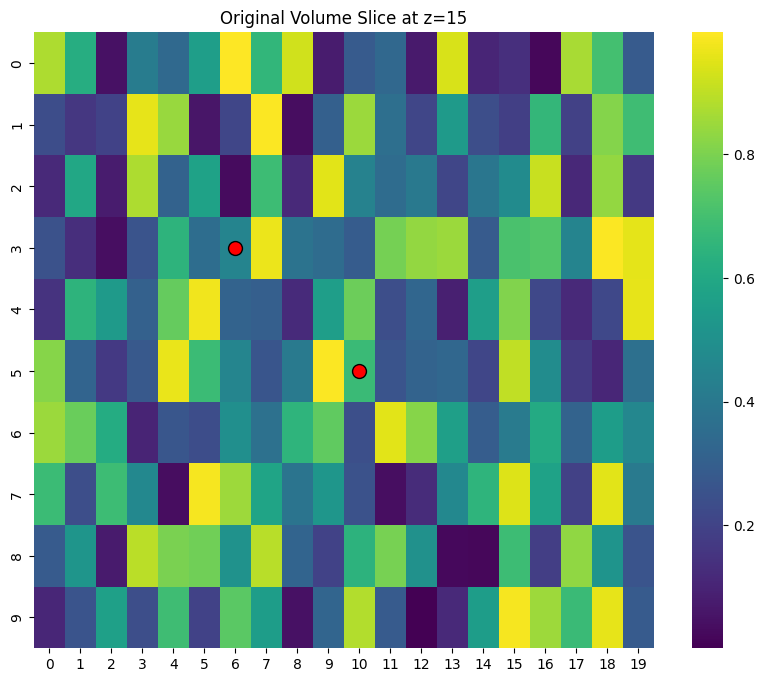

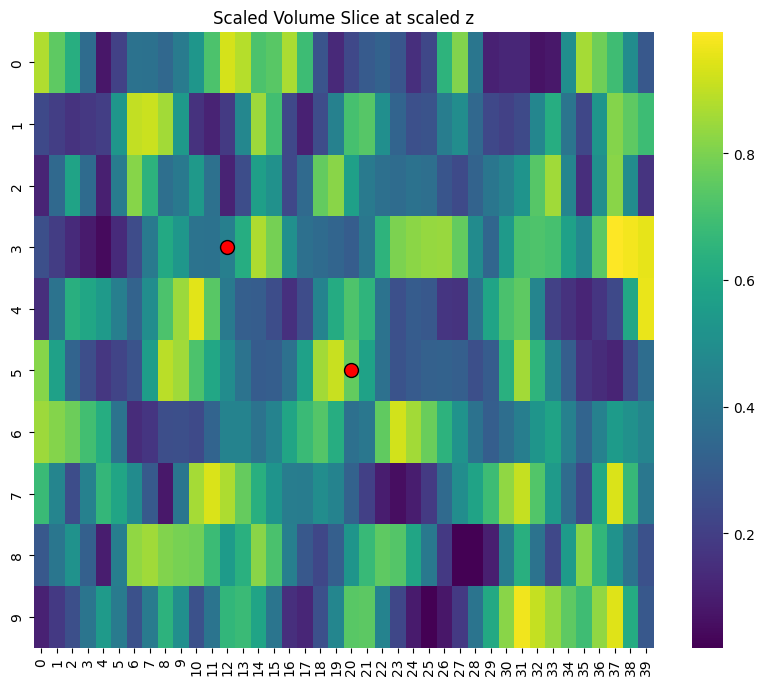

In [1]:
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import seaborn as sns

def scale_3d_volume_and_coordinates(volume, scale_factors, coordinates):
    """
    Scales a 3D numpy array and a list of 3D coordinates by the given scale factors.

    Parameters:
    - volume: 3D numpy array to be scaled.
    - scale_factors: List of scale factors for each dimension.
    - coordinates: List of 3D coordinates to be scaled.

    Returns:
    - scaled_volume: Scaled 3D numpy array.
    - scaled_coordinates: List of scaled 3D coordinates.
    """
    # Scale the volume
    scaled_volume = zoom(volume, scale_factors, order=1)  # Order=1 for linear interpolation
    
    # Scale the coordinates
    scale_matrix = np.diag(scale_factors)
    scaled_coordinates = [np.dot(scale_matrix, coord) for coord in coordinates]

    return scaled_volume, np.array(scaled_coordinates)

def plot_heatmap_with_points(array, points, title):
    """
    Plot a 2D heatmap of the given array and overlay points on top of it.

    Parameters:
    - array: 2D numpy array to be plotted as a heatmap.
    - points: List of points to be overlaid, each point is a tuple (x, y).
    - title: Title for the plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(array, cmap='viridis', cbar=True)
    
    for point in points:
        plt.scatter(point[1] + 0.5, point[0] + 0.5, color='red', s=100, edgecolor='black')
    
    plt.title(title)
    plt.show()

# Example usage
volume = np.random.rand(10, 20, 30)  # Example 3D volume
scale_factors = [1.0, 2.0, 1.0]  # Scale factors for z, x, y respectively
coordinates = np.array([[5, 10, 15], [3, 6, 9]])  # Example 3D coordinates

scaled_volume, scaled_coordinates = scale_3d_volume_and_coordinates(volume, scale_factors, coordinates)

print("Original Volume Shape:", volume.shape)
print("Scaled Volume Shape:", scaled_volume.shape)
print("Scaled Coordinates:", scaled_coordinates)

# Plot a slice before and after scaling
plot_heatmap_with_points(volume[:, :, 15], coordinates[:, [0, 1]], 'Original Volume Slice at z=15')
plot_heatmap_with_points(scaled_volume[:, :, int(15 * scale_factors[2])], scaled_coordinates[:, [0, 1]], 'Scaled Volume Slice at scaled z')